In [1]:
import numpy as np
from numpy.linalg import inv
import time
import hankel
from hankel import HankelTransform
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.special as scs

# progress tracker
import time, sys
from IPython.display import clear_output

def update_progress(progress,msg=''):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
            
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = msg+"Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

# Functions

In [2]:
## vertical slowness and transformation matrices

def tlQLmatrices(layer, p):
    # based on Ursin and Stovas, Geophysics (2003)
    [c11, c13, c33, c44, d]=layers[layer];
    a0 = np.sqrt(c33/d);
    b0 = np.sqrt(c44/d);
    s0 = 1-c44/c33;
    dD = (c13 - c33 + 2*c44)/c33;
    eta = (c11*c33 - (c13 + 2*c44)**2)/(2*c33**2);
    R1 = 2*(1 - p**2*b0**2)*(dD + 2*p**2*a0**2*eta)**2;
    R2 = s0 + 2*p**2*b0**2*dD - 2*p**2*a0**2*(1 - 2*p**2*b0**2)*eta;
    R = R1/(R2 + np.sqrt(R2**2 + 2*p**2*b0**2*R1));
    Sa = 2*dD + 2*p**2*a0**2*eta + R
    Sb = 2*(1 - p**2*b0**2)*a0**2/b0**2*eta - R
    q1 = 1/a0**2 - p**2 - p**2*Sa;
    q2 = 1/b0**2 - p**2 - p**2*Sb;
    qa = np.sqrt(q1.real + 1j*abs(q1.imag));
    qb = np.sqrt(q2.real + 1j*abs(q2.imag));
    
    d2 = np.sqrt((s0 + dD)/(s0 + Sa));
    d3 = 2*b0**2*(s0 + 
     1/2*(Sa + dD))/(s0 + dD);
    d4 = np.sqrt((s0 - p**2*b0**2*(s0 + Sb))/((1 - p**2*b0**2*(1 + Sb))*(s0 + dD)));
    d5 = (s0 - 2*p**2*b0**2*(s0 + 1/2*(Sb + dD)))/(s0 + dD);
    d1 = 1/np.sqrt(p**2*d3 + d5);
    L1 = d1*np.array([[d2*np.sqrt(qa/d), 1/d4*p/np.sqrt(d*qb)],
                      [d3*d2*p*np.sqrt(d*qa), -d5/d4*np.sqrt(d/qb)]
                     ], dtype = np.complex_);
    L2 = d1*np.array([[d5/d2*np.sqrt(d/qa), d3*d4*p*np.sqrt(d*qb)],
                      [1/d2*p/np.sqrt(d*qa), -d4*np.sqrt(qb/d)]
                     ], dtype = np.complex_);
    return(np.array([np.diagflat([qa,qb]),L1,L2]))


## reflection and transmission coefficients for a single interface
def tlLayerReflectionTransmission(layer1, layer2, p):
    # based on Ursin and Stovas, Geophysics (2002)
    # no need to use slownesses. Get the L matrices only
    # and use equations B-1, B-2 to calculate T, R
    [L1t, L2t] = tlQLmatrices(layer1, p)[1:5];
    [L1b, L2b] = tlQLmatrices(layer2, p)[1:5];
    
    # C and D as defined in eq. B-2
    C = np.dot(L2t.T, L1b);
    D = np.dot(L1t.T, L2b);
    
    # Reflection and transmission matrices of a single interface
    trans = 2*inv(C + D)
    refl = np.dot((C-D),trans/2)
    
    return(np.array([trans,refl]))

## stack reflectivity
def tlReflectivity(layers, thicknesses, p, w):
    # based on Ursin and Stovas, Geophysics (2002)
    # Recursion is eq. 20
    n_of_layers = len(layers)-1;
    
    # set thickness of the upper half-space to 0
    thicknesses[0] = 0;
    
    # QL matrices for layer stack
    QL = [tlQLmatrices(i,p) for i in layers];
    
    # Pairwise reflection transmission for layer stack
    RT = [tlLayerReflectionTransmission(layers[i],layers[i+1], p) for i in range(n_of_layers)]
    
    # Phase propagator for layer stack
    phase = [np.diagflat(np.exp(1j*w*i[0]*np.diag(i[1]))) for i in zip(thicknesses,[item[0] for item in QL])]
    
    # Recursive calculation of reflection response
    def rec(n):
        if n == n_of_layers-1:
            return(np.zeros(shape=(2,2), dtype=np.complex_))
        else:
            inv_mat = inv(np.identity(2, dtype=np.complex_) + np.dot(RT[n+1][1],rec(n+1)))
            inv_t = np.dot(np.transpose(RT[n+1][0]) , np.dot(rec(n+1) , np.dot(inv_mat , RT[n+1][0])))
            return(np.dot(np.dot(phase[n + 1],RT[n + 1][1] + inv_t),phase[n + 1]))
    return(rec(-1))

## response due to a vertical source
def tlResponseVforce(layers, thicknesses, p, w, zSource, zReceiver):
    # QL matrices of the upper half-space
    QLtop = tlQLmatrices(layers[0],p);
    
    # phase due to the source
    phaseSource = np.diagflat(np.exp(-1j*w*zSource*np.diag(QLtop[0])));
    phaseReceiver = np.diagflat(np.exp(1j*w*zReceiver*np.diag(QLtop[0])));
    
    # vertical force
    vforce = np.array([1/w,0]);
    
    # source discontinuity vector
    Sigma = 1/np.sqrt(2) * np.dot(QLtop[1].T, vforce);
    
    # receiver-adjusted reflectivity
    refReceiver = np.dot(np.dot(phaseReceiver,tlReflectivity(layers, thicknesses, p, w)), phaseReceiver)
    
    # wavefield vector
    u = np.dot(np.dot(refReceiver, phaseSource), Sigma );
    
    # displacement vector
    b = 1/np.sqrt(2) * w * np.array([1j * np.dot(QLtop[1], u)[0], np.dot(QLtop[2], u)[1]])
    
    return(b)
    

## critical horizontal slowness
def getpmax(layers,model):
    phor = [np.real(np.sqrt(layers[x][4]/layers[x][3])) for x in model]
    return max(phor)

## discrete Hankel transfrom
def tlDHTR(f, nu, offsets, rmax, jzero):
    vec = jzero * np.pi / jzero[-1];
    scorrection = np.sin(vec)/vec;
    dhtlist = 2/(rmax **2 * scs.jv(nu+1, jzero) **2);
    return [np.dot(scorrection * dhtlist * f, scs.jv(nu, jzero * r/rmax)) for r in offsets]

## Ricker wavelet
def ricker(w,wp,dt=0):
    return (2* w**2)/(np.sqrt(np.pi)* wp**3)* np.exp(-w**2/wp**2) * np.exp(-1j * dt* w)

## f-t trace transfrom
def ftot(tresp,omega,w0 = 25):
    src = ricker(omega,2*np.pi*w0)
    taxis = np.arange(2*len(omega)+1)/(omega[1]/2/np.pi)/(2*len(omega))
    traceSrc = tresp * src #* (1j* omega) ** 2
    tracef = np.concatenate(([0],traceSrc,np.conj(np.flip(traceSrc,0))))
    return taxis, np.real(np.fft.fft(tracef))

In [3]:
def FKmodeling(model, pI=0.0075, msg=''):
    
    # default values if not supplied
    try:
        omega = model['omega']
    except:
        omega = 2*np.pi*np.arange(1,101)/2
        
    try:
        r = model['r']
    except:
        r = np.arange(0.05,2.1,0.05)
        
    try:
        nslow = model['nslow']
    except:
        nslow = 1000
    
    # get critical slowness (integration limit)
    pmax = 1.05*getpmax(model['layers'],model['model_layers'])

    # Zeroes of the Bessel function (components are 0: Z, 1: R )
    jzeros = np.array([scs.jn_zeros(0,nslow), scs.jn_zeros(1,nslow)]);

    # functions to transform (u[0] - Z, u[1] - R)
    u = lambda k,w: tlResponseVforce(model['model_layers'],model['model_thickness'],k/w - pI*1j,w,model['zSource'],model['zReceiver'])

    # transfrom Z component
    tresp = []
    
    start = time.time()

    for i, w in enumerate(omega):
        inp = [u(k,w)[0] for k in jzeros[0]*pmax*w/jzeros[0,-1]]
        rmax = jzeros[0,-1] /pmax /w
        tranf = tlDHTR(inp, 0, r, rmax, jzeros[0])
        tresp.append(tranf)
        
        update_progress(i / len(omega),msg)
    end = time.time()
    elapsed = end - start
    print('...done. took '+str(elapsed)+' sec')
    
    tresp = np.array(tresp).T
    
    return tresp, omega, r, elapsed

# Numerical example

Define dictionary `layer` assigning a layer label with fixed, potentially complex elastic constants and density. The elastic constants correspond to an VTI medium and are to be given in order ($c_{11}, c_{13}, c_{33}, c_{44}, \rho$).

Define another dictionary `model` to store the model/modeling parameters: layers, thickness, source and receiver depths, source frequency, frequency and offset vector, number of integration points

In [4]:
layers={
    "layer 1":(22.56, 12.38, 17.35, 3.15, 2.38),
    "layer 2":(26.73, 12.51, 26.73, 7.11, 2.22),
    "layer 3":(11.25, 6.066, 11.25, 2.592, 1.8),
    "layer 4":(11.25 + 1j, 6.066, 26.25, 2.592, 1.8),
    "layer 5":(11.25 + 1j, 2.066, 19.25, 2.592, 1.8),
    "layer 6":(11.25 + 1j, 6.066, 23.25, 2.592, 1.8)
};

model={
    "layers": layers,
    "model_layers": (['layer 2', 'layer 1', 'layer 2']),
    "model_thickness":  [1,.4,1],
    "zSource":.4,
    "zReceiver":.8,
    "srcw": 15,
    "omega": 2*np.pi*np.arange(0.5,50.5,0.5),
    "r": np.arange(0.05,2.05,0.05),
    "nslow": 3000
}

## Hankel transfrom test (number of integration points)
*long computations, don't run*

In [6]:
# get gather in f-r domain
gatherF, omega, r, elapsed = FKmodeling(model,pI=0.01)

# transform the gather into t-r domain
gather0 = np.array([ftot(gatherF[i],omega,model['srcw'])[1] for i in range(len(gatherF))])
taxis = ftot(gatherF[1],omega)[0]

Progress: [####################] 99.0%
...done


In [19]:
Npts = np.arange(100,2100,100)

error = []
timevec = []
for i, nslow in enumerate(Npts):
    model["nslow"] = nslow
    gatherF, omega, _, elapsed = FKmodeling(model,pI=0.01,msg='i = '+str(i+1)+'/'+str(len(Npts))+', ')
    timevec.append(elapsed)
    gather = np.array([ftot(gatherF[i],omega,model['srcw'])[1] for i in range(len(gatherF))])
    error.append(np.sum(np.abs(gather - gather0)))

Progress: [####################] 99.0%
...done. took 253.68127465248108 sec


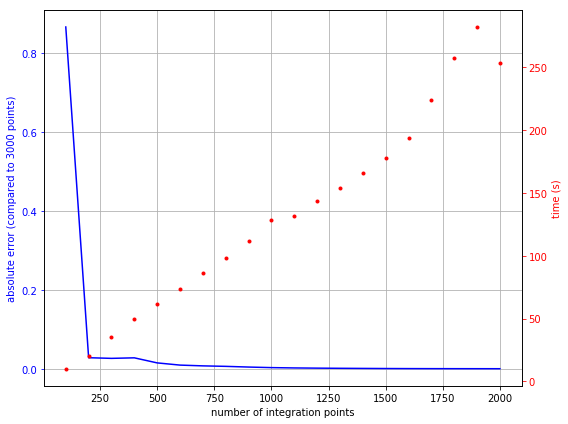

In [25]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(Npts, error, 'b-')
ax1.set_ylabel('absolute error (compared to 3000 points)', color='b')
ax1.set_xlabel('number of integration points')
ax1.tick_params('y', colors='b')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(Npts, timevec, 'r.')
ax2.set_ylabel('time (s)', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

## Hankel transfrom test (number of layers)
*long computations, don't run*

In [8]:
Ncases = 15
model['nslow'] = 100
model['model_layers'] = ['layer 2', 'layer 1']
model['model_thickness'] = [1,1]

timevec = []
gathers = []
for i in range(Ncases):
    if i % 2 ==0:
        model['model_layers'].append('layer 2')
    else:
        model['model_layers'].append('layer 1')
    
    model['model_thickness'].insert(-1,0.1 + 0.1 *np.random.random())
        
    gatherF, omega, r, elapsed = FKmodeling(model,pI=0.01,msg='i = '+str(i+1)+'/'+str(Ncases)+', ')
    timevec.append(elapsed)
    gather = np.array([ftot(gatherF[i],omega,model['srcw'])[1] for i in range(len(gatherF))])
    gathers.append(gather)

i = 14/15, Progress: [####################] 99.0%
...done. took 15927.172839641571 sec


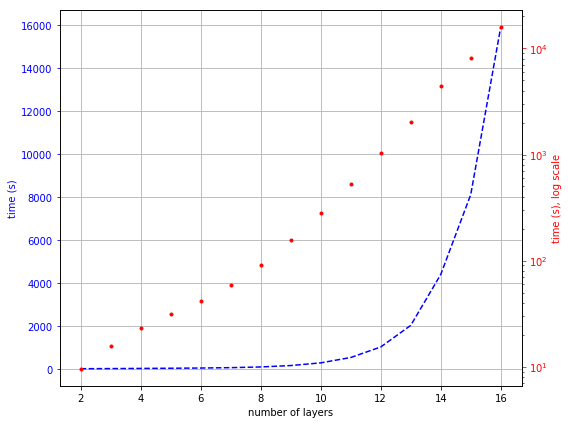

In [28]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(np.arange(Ncases)+2, timevec, 'b--')
ax1.set_ylabel('time (s)', color='b')
ax1.set_xlabel('number of layers')
ax1.tick_params('y', colors='b')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(np.arange(Ncases)+2, timevec, 'r.')
ax2.set_ylabel('time (s), log scale', color='r')
ax2.tick_params('y', colors='r')
ax2.set_yscale('log')
fig.tight_layout()
plt.show()

## Some other examples

KeyboardInterrupt: 

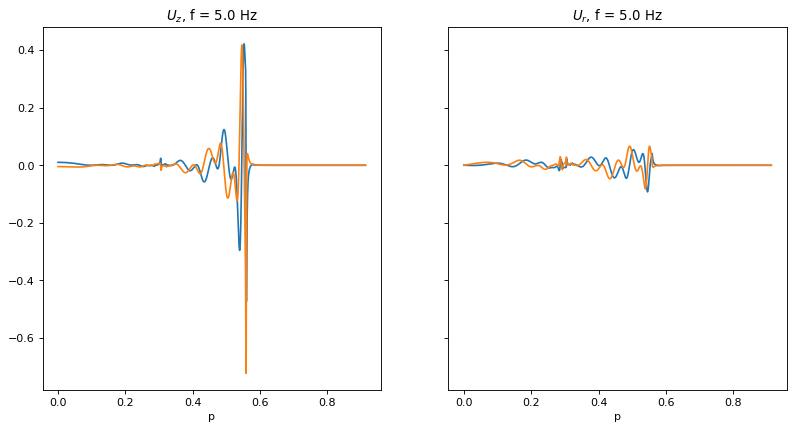

In [5]:
%%time
# get critical slowness (integration limit)
pmax = 1.05*getpmax(layers,model_layers)
# number of integration points
nslow = 3000
# Zeroes of the Bessel function (components are 0: Z, 1: R )
jzeros = np.array([scs.jn_zeros(0,nslow), scs.jn_zeros(1,nslow)]);

# functions to transform (u[0] - Z, u[1] - R)
def u(k,w,pI=0.001): return tlResponseVforce(model_layers,model_thickness,k/w - pI*1j,w,zSource,zReceiver)

# example plots
w = 2 * np.pi * 5
slow = jzeros[0]*pmax/jzeros[0,-1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi= 80, sharey=True)

axs[0].set_title('$U_z$, f = ' + str(w/2/np.pi) + ' Hz')
axs[0].plot(slow,np.real([u(p*w,w)[0] for p in slow]))
axs[0].plot(slow,np.imag([u(p*w,w)[0] for p in slow]))
axs[0].set_xlabel('p')

axs[1].set_title('$U_r$, f = ' + str(w/2/np.pi) + ' Hz')
axs[1].plot(slow,np.real([u(p*w,w)[1] for p in slow]))
axs[1].plot(slow,np.imag([u(p*w,w)[1] for p in slow]))
axs[1].set_xlabel('p')

# frequency vector
dw = 0.25
nw = 800
omega = 2*np.pi* np.arange(dw,dw*(nw+1),dw)
# offset vector
r = np.arange(0.025,2.1,0.025)

# transfrom Z component
tresp = []

for w in omega:
    inp = [u(k,w)[0] for k in jzeros[0]*pmax*w/jzeros[0,-1]]
    rmax = jzeros[0,-1] /pmax /w
    tranf = tlDHTR(inp, 0, r, rmax, jzeros[0])
    tresp.append(tranf)
    
tresp = np.array(tresp).T

In [22]:
taxis, trace = ftot(tresp[0],omega,10)
plt.plot(taxis,trace)
taxis, trace = ftot(tresp[int(len(tresp)/2)],omega,10)
plt.plot(taxis,trace)
taxis, trace = ftot(tresp[-1],omega,10)
plt.plot(taxis,trace)

NameError: name 'tresp' is not defined

In [23]:
gather = np.array([ftot(tresp[i],omega,15)[1] for i in range(len(tresp))])

(1, 0)

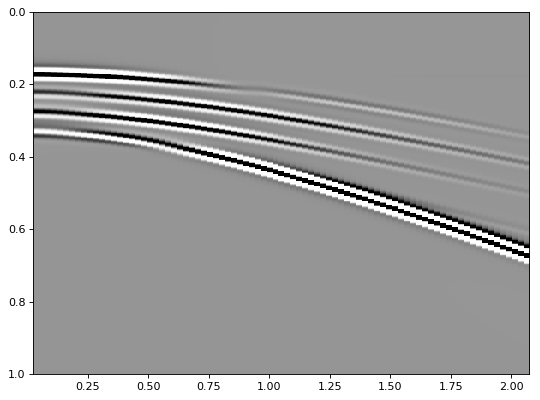

In [24]:
drange = [np.amin(r), np.amax(r), np.amax(taxis), np.amin(taxis)];
vm = np.percentile(gather, 99)

plt.figure(figsize=(8, 6), dpi= 80)
plt.imshow(gather.T, cmap="Greys", vmin=-vm, vmax=vm, aspect='auto', extent=drange)
plt.ylim([1,0])

In [42]:
# HT using the hankel package (so far no success)
pmax = getpmax(layers,model_layers)
nslow = 300
dslow = pmax/nslow

def u(k,w,pI=0.001): return tlResponseVforce(model_layers,model_thickness,k/w - pI*1j,w,zSource,zReceiver)[0]

r = .5;

omega = 2*np.pi* np.arange(1,101)/2
tresp = []
for w in omega:
    ht = HankelTransform(nu=0,N=nslow,h=dslow * w)
    inp_func = np.vectorize(lambda k : u(k, w))
    tranf = ht.transform(inp_func, r, ret_err=False, inverse=True)
    tresp.append(tranf)

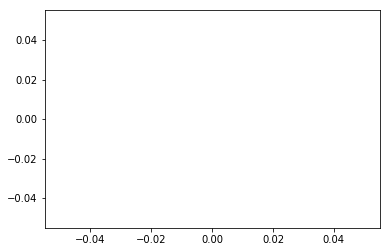

In [43]:
taxis,trace = ftot(tresp,omega,10)
plt.plot(taxis,trace)